In [1]:
import numpy as np
from pytorch_lightning import seed_everything, LightningModule, Trainer
from sklearn.utils import class_weight
import torch.nn as nn
import torch
from torch.utils.data.dataloader import DataLoader
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor
from torch.optim.lr_scheduler import CyclicLR, ReduceLROnPlateau,CosineAnnealingWarmRestarts,OneCycleLR,LambdaLR

import torchvision
from sklearn.metrics import classification_report,f1_score,accuracy_score
import matplotlib.pyplot as plt

In [2]:
import albumentations as A

from albumentations.pytorch import ToTensorV2

aug= A.Compose([
            A.Resize(256, 256),
            A.CenterCrop(224,224),
            A.Normalize(mean=(0,0,0), std=(1, 1, 1)),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [3]:
from torch.utils.data import DataLoader, Dataset
img_size=224
class MyLazyDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x=self.dataset[index][0]
        y=self.dataset[index][1]
        if self.transform:
            x=np.array(x)
            x=self.transform(image=x)['image']
        return x, y
    
    def __len__(self):
        return len(self.dataset)

In [4]:
train_split=torchvision.datasets.ImageFolder('splited_dataset/train')
ds=DataLoader(MyLazyDataset(train_split,aug), batch_size = 16, 
                          num_workers=0,shuffle=True)
image,label=next(iter(ds))
print(image.shape,label.shape)

torch.Size([16, 3, 224, 224]) torch.Size([16])


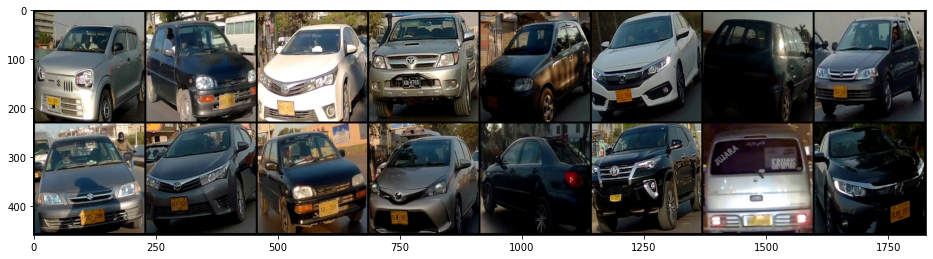

In [5]:
from torch.utils.data.dataloader import DataLoader
import torchvision
import matplotlib.pyplot as plt
plt.figure(figsize=(16,16))
grid_img=torchvision.utils.make_grid(image,8,4)
plt.imshow(grid_img.permute(1, 2, 0))

In [6]:
model_name='efficientnetv2_rw_s'

In [7]:
import timm
import torchmetrics
import torchvision.models as models
class OurModel(LightningModule):
    def __init__(self):
        super(OurModel,self).__init__()
        #architecute
        self.train_split=torchvision.datasets.ImageFolder('splited_dataset/train')
        self.test_split=torchvision.datasets.ImageFolder('splited_dataset/test')
        print(len(self.train_split), 'images in ',len(self.train_split.classes),' classes')
        self.model =  timm.create_model(model_name,pretrained=True)
        self.fc1=nn.Linear(1000,500)
        self.relu=nn.ReLU()
        self.fc2= nn.Linear(500,len(self.train_split.classes))
        #parameters
        self.lr=1e-3
        self.batch_size=48
        self.numworker=0
        self.acc = torchmetrics.Accuracy()
        self.criterion=nn.CrossEntropyLoss()

        self.trainacc,self.valacc=[],[]
        self.trainloss,self.valloss=[],[]
    def forward(self,x):
        x= self.model(x)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        return x
    
    def mixup_data(self,x, y, alpha=1.0):
        '''Returns mixed inputs, pairs of targets, and lambda'''
        if alpha > 0:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1

        batch_size = x.size()[0]
        index = torch.randperm(batch_size)
        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam


    def mixup_criterion(self, pred, y_a, y_b, lam):
        return lam * self.criterion(pred, y_a) + (1 - lam) * self.criterion(pred, y_b)
    
    def configure_optimizers(self):
        opt=torch.optim.AdamW(params=self.parameters(),lr=self.lr )
        return opt

    def train_dataloader(self):
        return DataLoader(MyLazyDataset(self.train_split,aug), batch_size = self.batch_size, 
                          num_workers=self.numworker,shuffle=True)

    def training_step(self,batch,batch_idx):
        image,label=batch
        mixed_x, y_a, y_b, lam=self.mixup_data(image,label)
        out = self(mixed_x)
        loss=self.mixup_criterion(out,y_a, y_b, lam)
        acc=self.acc(out,label)
        return {'loss':loss,'acc':acc}

    def training_epoch_end(self, outputs):
        loss=torch.stack([x["loss"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        acc=torch.stack([x["acc"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        print('training loss accuracy ',loss, acc)
        self.trainacc.append(acc)
        self.trainloss.append(loss)
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        
    def val_dataloader(self):
        ds=DataLoader(MyLazyDataset(self.test_split,aug), batch_size = self.batch_size,
                      num_workers=self.numworker, shuffle=False)
        return ds

    def validation_step(self,batch,batch_idx):
        image,label=batch
        out=self(image)
        loss=self.criterion(out,label)
        acc=self.acc(out,label)
        return {'loss':loss,'acc':acc}

    def validation_epoch_end(self, outputs):
        loss=torch.stack([x["loss"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        acc=torch.stack([x["acc"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        self.valacc.append(acc)
        self.valloss.append(loss)
        print('validation loss accuracy ',loss, acc)
        self.log('val_loss', loss)
        self.log('val_acc', acc)


    def test_dataloader(self):
        return DataLoader(MyLazyDataset(self.test_split,aug), batch_size = self.batch_size,num_workers=self.numworker, shuffle=False)

    def test_step(self,batch,batch_idx):
        image,label=batch
        out=self(image)
        loss=self.criterion(out,label)
        return {'loss':loss,'pred':out,'label':label}
    def test_epoch_end(self, outputs):
        loss=torch.stack([x["loss"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        pred=torch.cat([x["pred"] for x in outputs]).detach().cpu().numpy()
        label=torch.cat([x["label"] for x in outputs]).detach().cpu().numpy()
        pred=np.argmax(pred,1)
        print(classification_report(label,pred,target_names=self.train_split.class_to_idx))
        acc=accuracy_score(label,pred)


In [8]:
#read api from trext file
with open('api.txt') as f:
    api=f.readline()

In [9]:

from neptune.new.integrations.pytorch_lightning import NeptuneLogger
seed_everything(0)
neptune_logger = NeptuneLogger(
            api_key=api,
            project='mrtictac96/pakvehicle', 
            close_after_fit=False,
            name='mixup_effnet',
            tags='mixup_effnet'
        )

Global seed set to 0


In [10]:
model = OurModel()

3106 images in  48  classes


In [11]:
es=EarlyStopping(monitor="val_loss",patience=10, verbose=True)
seed_everything(0)
lr_monitor = LearningRateMonitor(logging_interval='epoch')

trainer = Trainer(max_epochs=50, auto_lr_find=True, auto_scale_batch_size=False,
                  deterministic=True,
                  gpus=-1,precision=16,
                  accumulate_grad_batches=8,
                  stochastic_weight_avg=True,
                  progress_bar_refresh_rate=0,
                  log_every_n_steps=5,
                  logger=neptune_logger
                  )
#trainer.tune(model)



Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


In [12]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\anaconda3\lib\site-packages\neptune\new\internal\utils\git.py:34: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")


https://app.neptune.ai/mrtictac96/pakvehicle/e/PAKVEHICLE-63
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.



  | Name      | Type             | Params
-----------------------------------------------
0 | model     | EfficientNet     | 23.9 M
1 | fc1       | Linear           | 500 K 
2 | relu      | ReLU             | 0     
3 | fc2       | Linear           | 24.0 K
4 | acc       | Accuracy         | 0     
5 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
24.5 M    Trainable params
0         Non-trainable params
24.5 M    Total params
97.863    Total estimated model params size (MB)
C:\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Global seed set to 0


validation loss accuracy  3.9 0.0


C:\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


training loss accuracy  3.23 0.19
validation loss accuracy  1.77 0.59
training loss accuracy  2.13 0.4
validation loss accuracy  0.82 0.82
training loss accuracy  1.66 0.48
validation loss accuracy  0.64 0.88
training loss accuracy  1.49 0.49
validation loss accuracy  0.55 0.9
training loss accuracy  1.21 0.46
validation loss accuracy  0.48 0.93
training loss accuracy  1.2 0.44
validation loss accuracy  0.47 0.93
training loss accuracy  1.14 0.49
validation loss accuracy  0.46 0.94
training loss accuracy  1.13 0.53
validation loss accuracy  0.43 0.93
training loss accuracy  1.09 0.52
validation loss accuracy  0.39 0.93
training loss accuracy  0.95 0.44
validation loss accuracy  0.36 0.94
training loss accuracy  1.09 0.54
validation loss accuracy  0.36 0.94
training loss accuracy  0.97 0.47
validation loss accuracy  0.39 0.94
training loss accuracy  0.93 0.52
validation loss accuracy  0.35 0.94
training loss accuracy  0.92 0.58
validation loss accuracy  0.36 0.94
training loss accuracy 

Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute metrics/val_loss


training loss accuracy  0.7 0.5
validation loss accuracy  nan 0.94


Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute metrics/val_loss


training loss accuracy  0.79 0.5
validation loss accuracy  nan 0.94


Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute metrics/val_loss


training loss accuracy  0.78 0.48
validation loss accuracy  nan 0.94


Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute metrics/val_loss


training loss accuracy  0.75 0.51
validation loss accuracy  0.3 0.95
training loss accuracy  0.7 0.52
validation loss accuracy  0.28 0.96
training loss accuracy  0.72 0.52
validation loss accuracy  0.31 0.95
training loss accuracy  0.69 0.58
validation loss accuracy  0.29 0.96
training loss accuracy  0.64 0.56
validation loss accuracy  0.26 0.95
training loss accuracy  0.57 0.54
validation loss accuracy  0.24 0.96
training loss accuracy  0.71 0.49
validation loss accuracy  0.29 0.95
training loss accuracy  0.67 0.54
validation loss accuracy  0.29 0.95
training loss accuracy  0.63 0.51
validation loss accuracy  0.25 0.96
training loss accuracy  0.67 0.54
validation loss accuracy  0.27 0.95
training loss accuracy  0.65 0.49
validation loss accuracy  0.27 0.95
training loss accuracy  0.66 0.53
validation loss accuracy  0.29 0.95
training loss accuracy  0.62 0.53
validation loss accuracy  0.23 0.96
training loss accuracy  0.6 0.59
validation loss accuracy  0.27 0.95
training loss accuracy 

In [13]:
#model.load_state_dict(torch.load('./trainedmodel96acc.pt'))

In [14]:
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


                        precision    recall  f1-score   support

          Daiatsu_Core       0.95      0.95      0.95        20
         Daiatsu_Hijet       0.83      1.00      0.91        10
          Daiatsu_Mira       1.00      1.00      1.00        20
                FAW_V2       1.00      1.00      1.00         7
               FAW_XPV       1.00      0.83      0.91         6
             Honda_BRV       1.00      1.00      1.00         6
     Honda_City_aspire       0.93      0.96      0.94        26
           Honda_Grace       0.75      0.60      0.67         5
          Honda_Vezell       1.00      1.00      1.00         9
       Honda_city_1994       0.88      1.00      0.93         7
       Honda_city_2000       0.88      0.88      0.88        17
      Honda_civic_1994       1.00      1.00      1.00         4
      Honda_civic_2005       1.00      0.88      0.93         8
      Honda_civic_2007       0.95      1.00      0.97        18
      Honda_civic_2015       0.67      

[{}]

In [15]:
torch.save(model.state_dict(), './weights/mixup_effnet.pt')

In [16]:
neptune_logger.experiment.stop()


Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 13 operations to synchronize with Neptune. Do not kill this process.


All 13 operations synced, thanks for waiting!


# grad cam

In [12]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
target_layer = model.model.features.denseblock4.denselayer16
cam = GradCAMPlusPlus(model=model, target_layer=target_layer, use_cuda='cuda')
model.load_state_dict(torch.load('./weights/mixup_densenet121.pt'))

<All keys matched successfully>

In [13]:
test_aug= A.Compose([
            A.Resize(256, 256),
            A.CenterCrop(224,224),
            A.Normalize(mean=(0,0,0), std=(1, 1, 1)),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [14]:
from PIL import Image
img=Image.open('./images/test_car_1.jpg')
img=test_aug(image=np.array(img))['image']
img=img.unsqueeze(0)
print(img.shape)

torch.Size([1, 3, 224, 224])


In [15]:
model=model.cuda()
pred=model(img.cuda())
pred=torch.argmax(pred,1)

In [21]:
pred=int(pred.cpu().numpy())
pred_class=model.train_split.classes[pred]
pred_class

'Suzuki_Mehran'

In [22]:
camout = cam(input_tensor=img, target_category=18,aug_smooth=True)

In [23]:
new_image=np.moveaxis(img.squeeze(0).numpy(),0,2)
new_image.shape

(224, 224, 3)

In [24]:
output=show_cam_on_image(new_image , camout.squeeze(0))
output.shape

(224, 224, 3)

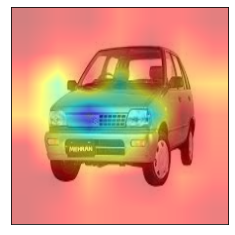

In [25]:
plt.imshow(output)
plt.xticks([])
plt.yticks([])
plt.savefig('./images/cam/resnet/resmixup.png',bbox_inches='tight')